In [1]:
# import
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers

Using Theano backend.


In [55]:
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

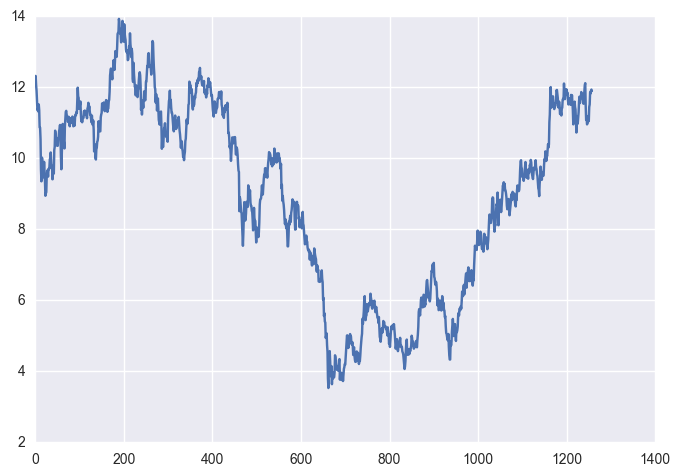

In [2]:
# load the close price
# plot it
data0 = pd.read_csv('./sber.csv')[::-1]
data = data0.ix[:, 'Adj Close'].tolist()
plt.plot(data)
plt.show()

In [3]:
WINDOW = 30
EMB_SIZE = 1
STEP = 1
FORECAST = 5

In [5]:
X, Y = [], []
for i in range(0, len(data)-WINDOW-FORECAST, STEP): 
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

    except Exception as e:
        print e
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] 

# comment it to remove normalization
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

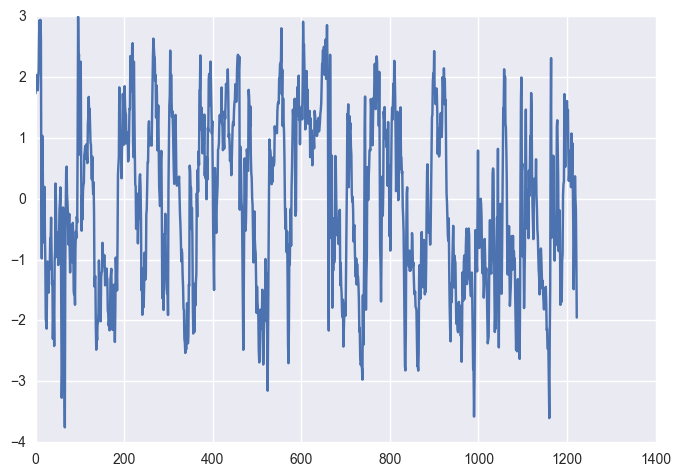

In [6]:
plt.plot(X[:,0])
plt.show()

In [7]:
model = Sequential()
model.add(Dense(64, input_dim=30,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dropout(0.5))
model.add(Dense(16,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))

opt = Nadam(lr=0.001)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=False)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 100, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

Train on 1100 samples, validate on 123 samples
Epoch 1/100
1100/1100 [==============================] - 0s - loss: 74.0360 - acc: 0.5000 - val_loss: 48.8666 - val_acc: 0.4228
Epoch 2/100
1100/1100 [==============================] - 0s - loss: 63.3735 - acc: 0.5064 - val_loss: 41.9777 - val_acc: 0.4634
Epoch 3/100
1100/1100 [==============================] - 0s - loss: 53.5047 - acc: 0.5018 - val_loss: 36.2930 - val_acc: 0.4878
Epoch 4/100
1100/1100 [==============================] - 0s - loss: 46.1851 - acc: 0.4945 - val_loss: 31.7505 - val_acc: 0.5122
Epoch 5/100
1100/1100 [==============================] - 0s - loss: 40.4853 - acc: 0.4955 - val_loss: 28.1881 - val_acc: 0.5122
Epoch 6/100
1100/1100 [==============================] - 0s - loss: 36.1355 - acc: 0.5127 - val_loss: 25.2854 - val_acc: 0.5041
Epoch 7/100
1100/1100 [==============================] - 0s - loss: 32.1933 - acc: 0.5245 - val_loss: 22.8967 - val_acc: 0.4797
Epoch 8/100
1100/1100 [==============================] - 

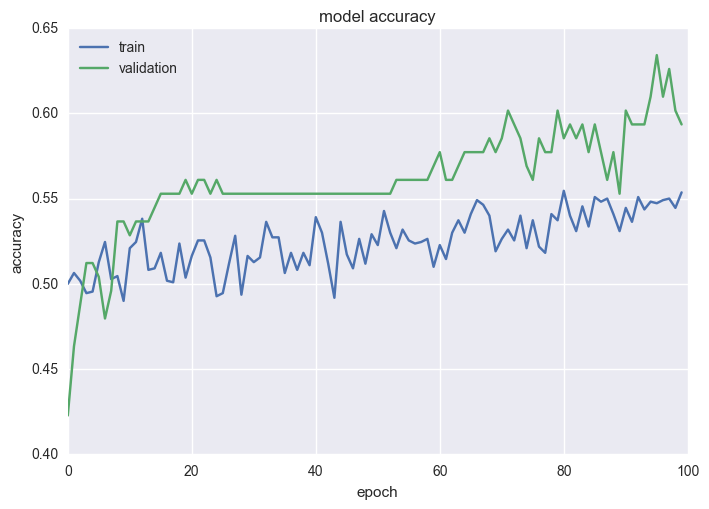

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
prediction = model.predict(X)

In [58]:
capital = 100
cap = [100]
for i in range(0, len(data)-WINDOW-FORECAST, STEP): 
    if prediction[i][0] > 0.54:
        capital = capital * data[i+31] / data[i+30]
    elif prediction[i][0] < 0.46:
        capital = capital * data[i+30] / data[i+31]
    cap.append(capital)

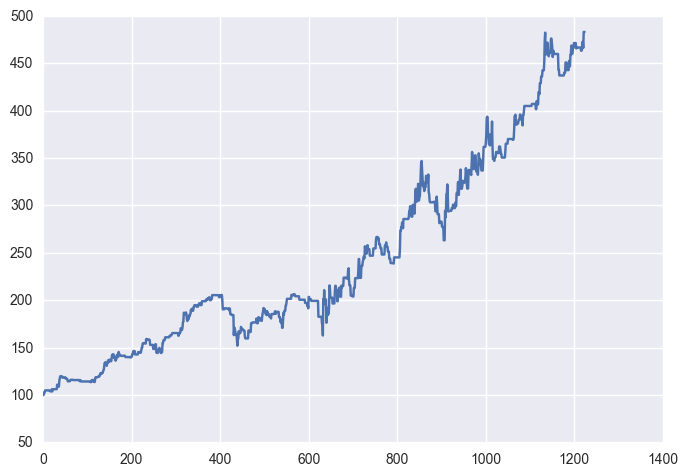

In [59]:
plt.plot(cap)
plt.title('Tra')
plt.show()

In [43]:
data[35]

10.158728999999999